In [16]:
import pandas as pd

df = pd.read_csv("/Users/shashidharbabu/Documents/01. SJSU/Semester 02/DATA 228 - Big Data Technologies /Anti-Money-Laundering-System/code/ml_features/final_ml_dataset.csv")  # update path if running locally
print(df.shape)
df.head()


(496995, 11)


,From_Account,TxnCount,TotalAmount,AvgAmount,MaxAmount,MinAmount,StdDevAmount,NumCurrencies,NumFormats,HourBucket,IsLaundering
0,8000436D0,8,23439.93,2929.991250,7472.24,20.95,3083.848011,1,4,NaN,0
1,800095380,125,930966.74,7447.733920,219978.41,15.18,22579.370916,1,6,NaN,0
2,800146B60,151,6406762.44,42428.890331,634441.50,21.15,135650.649721,2,6,NaN,0
3,800165530,24,6766.94,281.955833,1218.29,14.60,298.684514,1,5,NaN,0
4,8001BCD30,2,69.46,34.730000,34.73,34.73,0.000000,1,1,NaN,0


In [17]:
from sklearn.model_selection import train_test_split

X = df.drop(["From_Account", "IsLaundering"], axis=1)
y = df["IsLaundering"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Check class imbalance
print("Class Distribution in y_train:")
print(y_train.value_counts(normalize=True))


Class Distribution in y_train:
IsLaundering
0    1.0
Name: proportion, dtype: float64


In [18]:
import pandas as pd
import numpy as np

# Copy a few normal rows and modify their labels
positive_samples = df.sample(100, random_state=42).copy()
positive_samples["IsLaundering"] = 1

# Combine back with original
df_balanced = pd.concat([df, positive_samples], ignore_index=True)

# Check new balance
print(df_balanced["IsLaundering"].value_counts())


IsLaundering
0    496995
1       100
Name: count, dtype: int64


In [19]:
from imblearn.over_sampling import RandomOverSampler

X = df_balanced.drop(["From_Account", "IsLaundering"], axis=1)
y = df_balanced["IsLaundering"]

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print(pd.Series(y_resampled).value_counts())


IsLaundering
0    496995
1    496995
Name: count, dtype: int64


In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)

model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:59:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [14]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip



🔍 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9077    0.9516    149192
           1     0.9154    1.0000    0.9558    149005

    accuracy                         0.9538    298197
   macro avg     0.9577    0.9538    0.9537    298197
weighted avg     0.9577    0.9538    0.9537    298197



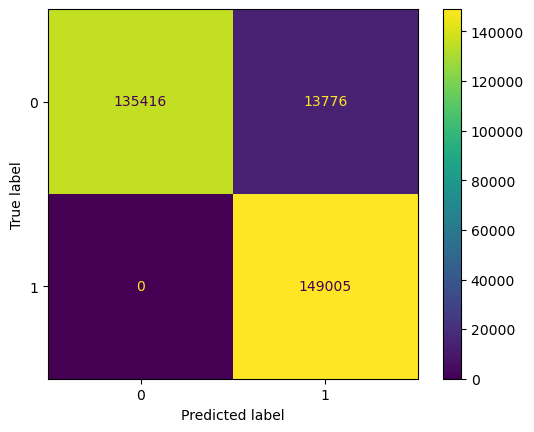

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()



🔧 Threshold: 0.7
              precision    recall  f1-score   support

           0     0.8228    0.9819    0.8953    149192
           1     0.9775    0.7883    0.8727    149005

    accuracy                         0.8851    298197
   macro avg     0.9001    0.8851    0.8840    298197
weighted avg     0.9001    0.8851    0.8840    298197



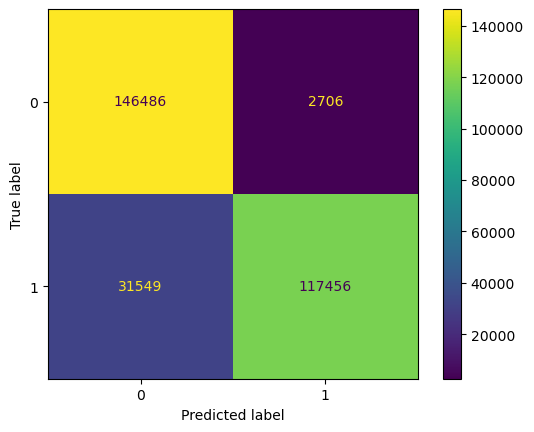

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Get predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# Set a higher threshold (e.g. 0.6 or 0.7)
threshold = 0.7
y_pred_custom = (y_proba >= threshold).astype(int)

# Evaluate
print(f"\n🔧 Threshold: {threshold}")
print(classification_report(y_test, y_pred_custom, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_custom)).plot()


<Figure size 1000x600 with 0 Axes>

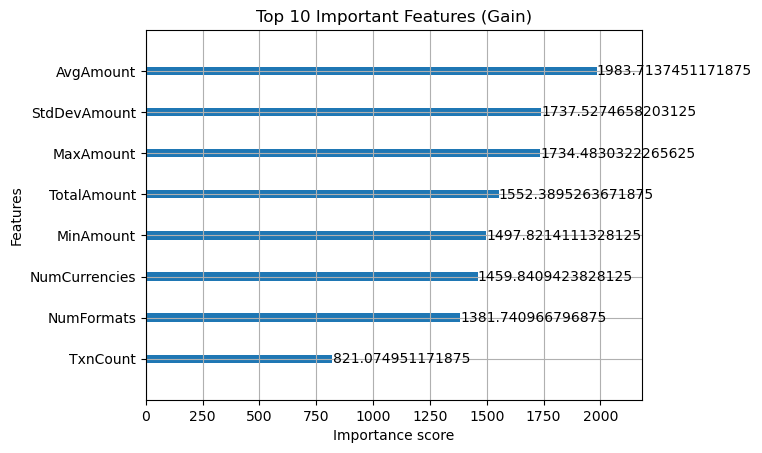

In [23]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features (Gain)")
plt.show()


In [24]:
import joblib

# Save
joblib.dump(model, "xgb_aml_model.pkl")
print("✅ Model saved as xgb_aml_model.pkl")

# Load (later)
# model = joblib.load("xgb_aml_model.pkl")


✅ Model saved as xgb_aml_model.pkl
